# Setup

In [1]:
import os
import sys
import seaborn as sns
from IPython.display import Image, display

In [2]:
# DySE modules
from Translation.model import get_model
from Simulation.Simulator_Python import simulator_interface
from Visualization import visualization_interface
from Extension.checker_extension import call_checker
from Translation.model import model_to_dict
from Extension.extension_interface import get_extensions
from Extension.topXReading import getAll
from Extension.geneticAlgorithm import initialize_ga_structure
from Extension.extension_util import extend_model
from py2cytoscape.data.cyrest_client import CyRestClient
from Translation.model import model_to_networkx
from Translation.model import model_to_sauce
from Translation.model import get_model_from_delphi,model_to_delphi,model_to_edges

In [3]:
def read_contents(filename):
    with open(filename) as this_file:
        file_content = this_file.read()
        
    return file_content

In [4]:
# logger setup
import logging
log_formatter = logging.Formatter("%(asctime)s [%(name)s] %(levelname)s : %(message)s")
logger = logging.getLogger()
log_handler = logging.StreamHandler()
log_handler.setFormatter(log_formatter)
logger.addHandler(log_handler)
logger.setLevel(logging.DEBUG)
logger.debug('test')
logger.setLevel(logging.ERROR)

2018-11-05 22:50:21,521 [root] DEBUG : test


In [5]:
logger.removeHandler(logger.handlers[0])
logger.info('test')

# DySE Framework

### Load Model from Table Data

In [6]:
from Translation.model import get_model

In [7]:
baseline_model_file = '../files/use_case_baseline.xlsx'
dyse_baseline_model = get_model(baseline_model_file)

In [8]:
# number of elements in baseline
dyse_baseline_model.shape[0]

20

In [9]:
# show tabular model format
dyse_baseline_model[['Element Name','Positive','Negative','Initial 0','Initial 1']]

,Element Name,Positive,Negative,Initial 0,Initial 1
Variable,,,,,
Conflict,Conflict,Road_accessibility,,1,0
Food_security,Food_security,Food_availability,,1,0
Heavy_rains,Heavy_rains,,,1,1
Flood,Flood,Heavy_rains,,1,1
Late_planting,Late_planting,Flood,,1,0
Failed_planting,Failed_planting,Flood,,1,0
Crop_yield,Crop_yield,,"Late_planting,Drought",1,0
Drought,Drought,,ENSO,1,1
ENSO,ENSO,,,1,2


### Simulate

In [10]:
from Simulation.Simulator_Python import simulator_interface

In [11]:
# simulate the baseline model
simulation_trace_file = 'simulation/use_case_baseline/output.txt'
%time simulator_interface.setup_and_run_simulation(baseline_model_file, simulation_trace_file, steps=50, runs=100, outputFormat=1)

CPU times: user 216 ms, sys: 0 ns, total: 216 ms
Wall time: 215 ms


In [12]:
# show part of the simulation trace file
traces = read_contents(simulation_trace_file)
print(traces[:500])

Run #0
Conflict|3| 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Crop_yield|3| 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Direct_aid|3| 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
Displacement|3| 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
Drought|3| 1 1 1 1 1 1 1 1 1 


### Plot simulation results

In [13]:
from Visualization import visualization_interface

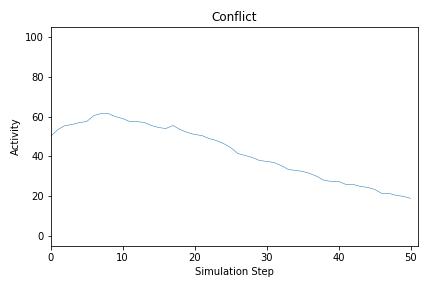

In [14]:
# plot results for the Conflict element
simulation_trace_file = 'simulation/use_case_baseline/output.txt'
plot_output_path_baseline = 'simulation/use_case_baseline/'
element = 'Conflict'
visualization_interface.plot_as_picture([simulation_trace_file], plot_output_path_baseline, elementsList=[element])
Image(plot_output_path_baseline + element + '.png')

### Model checking

In [15]:
from Extension.checker_extension import call_checker

In [16]:
test_file = '../files/checker_test.txt'
property_file = '../files/conflict_property.txt'

In [17]:
# define a property: is Conflict less than 1 (50%) in the first 20 time steps?
property_ = read_contents(property_file)
print(property_)

F[20](Conflict < 1)


In [18]:
# calculate the estimate that the property is satisfied
%time estimate = call_checker(test_file, property_file, baseline_model_file, 'checking/trace.txt', 'checking/estimate.txt','../../../../../Code/Framework', steps=50)
print('Estimate that property is satisfied: ' + str(estimate))

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 1min 51s
Estimate that property is satisfied: 0.219178


### Model extension

In [19]:
from Translation.model import model_to_dict
from Extension.extension_interface import get_extensions
from Extension.topXReading import getAll

In [20]:
# format model and extensions
extensions_file = '../files/extensions_sme.csv'
dyse_model_dict = model_to_dict(dyse_baseline_model)
extensions = get_extensions(dyse_model_dict, extensions_file)
clusters = getAll(extensions)

#### Iterative extension against a property

In [21]:
from Extension.geneticAlgorithm import initialize_ga_structure

In [22]:
test_file = '../files/checker_test.txt'
property_file = '../files/conflict_property.txt'
output_path = 'extension/iterative/'

In [23]:
# same property as before, is Conflict < 1 in the first 20 time steps?
property_ = read_contents(property_file)
print(property_)

F[20](Conflict < 1)


In [24]:
# run genetic algorithm to cluster extensions
# model extension will save/return any models that satisfy defined properties
%time initialize_ga_structure(baseline_model_file, clusters, output_path,test_file, property_file, 0.3, '../../../../../Code/Framework',n_generations=1,init_pop_size=3,ind_size=3,mu_individuals=3,lambda_num_children=3,steps=50)

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

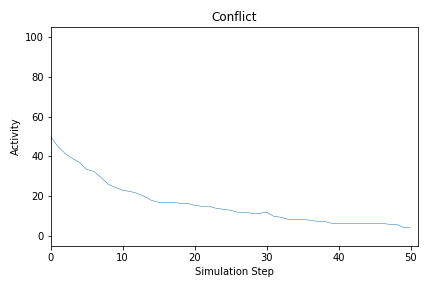

In [25]:
# simulate the extended model and plot results for the Conflict element
simulation_trace_file = 'simulation/use_case_extended_iterative/output.txt'
simulator_interface.setup_and_run_simulation('extension/iterative/final_2.xlsx', simulation_trace_file, steps=50, runs=100, outputFormat=1)
plot_output_path_extended_iterative = 'simulation/use_case_extended_iterative/'
element = 'Conflict'
visualization_interface.plot_as_picture([simulation_trace_file], plot_output_path_extended_iterative, elementsList=[element])
Image(plot_output_path_extended_iterative + element + '.png')

#### Add all possible extensions

In [26]:
from Extension.extension_util import extend_model

In [27]:
# add all extensions (skip clustering or iteration against a property)
extended_model_file = 'extension/use_case_extended.xlsx'
extend_model(baseline_model_file,clusters[0],extended_model_file)

In [28]:
# number of elements in extended model
extended_model = get_model(extended_model_file)
extended_model.shape[0]

38

#### Simulate extended model

In [29]:
# simulate the extended model
simulation_trace_file = 'simulation/use_case_extended/output.txt'
%time simulator_interface.setup_and_run_simulation(extended_model_file, simulation_trace_file, steps=50, runs=100, outputFormat=1)

CPU times: user 260 ms, sys: 8 ms, total: 268 ms
Wall time: 267 ms


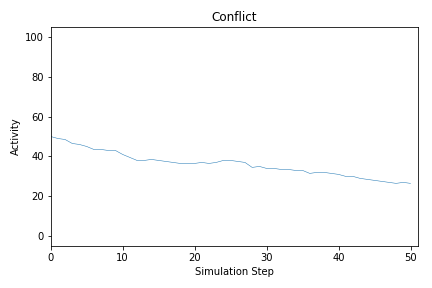

In [30]:
# plot results for the Conflict element (for the extended model)
simulation_trace_file = 'simulation/use_case_extended/output.txt'
plot_output_path_extended = 'simulation/use_case_extended/'
element = 'Conflict'
visualization_interface.plot_as_picture([simulation_trace_file], plot_output_path_extended, elementsList=[element])
Image(plot_output_path_extended + element + '.png')

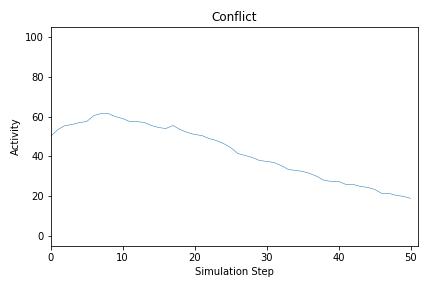

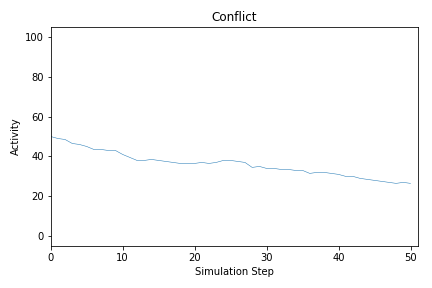

In [31]:
# compare plots for baseline and extended
for imgvar in [plot_output_path_baseline, plot_output_path_extended]:
    display(Image(imgvar + element + '.png',width=300))

#### Check extended model 

In [32]:
test_file = '../files/checker_test.txt'
property_file = '../files/conflict_property.txt'
extended_model_file = 'extension/use_case_extended.xlsx'

In [33]:
property_ = read_contents(property_file)
print(property_)

F[20](Conflict < 1)


In [34]:
# check extended model against a property
%time estimate = call_checker(test_file, property_file, extended_model_file, 'checking/trace.txt', 'checking/estimate.txt', '../../../../../Code/Framework', steps=50)
print('Estimate that property is satisfied: ' + str(estimate))

CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 2min 24s
Estimate that property is satisfied: 0.340206


### Integrations

#### NetworkX, Cytoscape export

In [35]:
import cyjs
from py2cytoscape.data.cyrest_client import CyRestClient
from Translation.model import model_to_networkx
import igraph

In [36]:
cy = cyjs.cyjs()
display(cy)

cyjs()

Define a function to obtain nodes, source/target lists, and interactions and create an igraph Graph:

In [37]:
def model_to_igraph(model):
    # extract relationships
    edges = model_to_edges(model)
    nodes = list(set(list(edges.regulator)) | set(list(edges.element)))
    sources = edges.element.tolist()
    targets = edges.regulator.tolist()
    interactions = edges.interaction.tolist()
    
    # generate igraph Graph
    g = igraph.Graph(directed=True)
    g.add_vertices(nodes)
    g.add_edges(zip(sources, targets))
    g.es['interaction'] = interactions
    
    return g

Generate model from `dyse_baseline_model`:

In [38]:
g = model_to_igraph(dyse_baseline_model)

Load the style file `style.js`.

Note: this specifies that an "increase" interaction will be denoted with a **green** arrow; a "decrease" interaction will be denoted with a **red** arrow.

In [39]:
cy.loadStyleFile("style.js")

Instantiate the graph:

In [40]:
cy.setHeight(800)
cy.addGraph(g)
kkLayout = g.layout("kk")
cy.setPosition(kkLayout)
cy.fit(40)

#### SAUCE export

In [41]:
from Translation.model import model_to_sauce

In [42]:
dyse_sauce_model = model_to_sauce(dyse_baseline_model)

In [43]:
dyse_sauce_model

defaultdict(None,
            {'name': '',
             'dateCreated': '',
             'createdBy': 'DySE Model Translator',
             'decisions': [{'id': 'Decision: Food_aid',
               'label': 'Simple Decision',
               'choices': [{'val': 0.0}, {'val': 1.0}, {'val': 2.0}]}],
             'utilities': [{'id': 'Utility: Food_security',
               'label': 'Simple Utility',
               'function': {'operation': '',
                'arguments': [{'ref': 'Food_security'}]}}],
             'parameters': [],
             'modelVariables': [{'id': 'Conflict',
               'label': 'Conflict',
               'description': 'other',
               'dtype': 'INT',
               'function': {'operator': '+',
                'arguments': [{'ref': 'Conflict'},
                 {'operator': '-',
                  'arguments': [{'val': 0},
                   {'operation': 'MAX',
                    'arguments': [{'ref': 'Road_accessibility'}]}]}]},
               'initia

#### Delphi

##### Delphi import

In [44]:
from Translation.model import get_model_from_delphi,model_to_delphi,model_to_edges

In [45]:
delphi_model_file = '../files/import/delphi_cag.json'

In [46]:
# load delphi model and convert to dyse format
dyse_delphi_model = get_model_from_delphi(delphi_model_file)

In [47]:
dyse_delphi_model[['Positive','Negative','Evidence']]

,Positive,Negative,Evidence
Variable,,,
food_insecurity,"market,conflict,flooding",,"From August to December 2015, harvesting-time..."
market,conflict,"food_insecurity,flooding",• Market functionality is severely limited by...
conflict,"food_insecurity,market,flooding",,INCREASE OF PRICES FOR STAPLE FOODS 150 South...
flooding,,,


##### Simulate imported delphi model

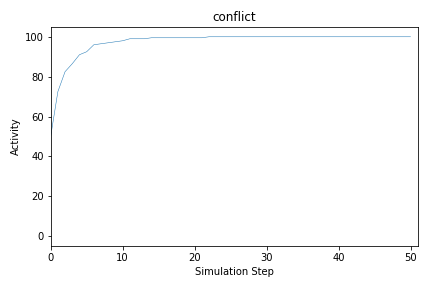

In [48]:
# simulate delphi model in dyse
dyse_delphi_export = 'export/delphi_to_dyse.xlsx'
simulation_trace_path = 'simulation/delphi_to_dyse/'
simulation_trace_file = os.path.join(simulation_trace_path,'output.txt')
dyse_delphi_model.to_excel(dyse_delphi_export)
simulator_interface.setup_and_run_simulation(dyse_delphi_export, simulation_trace_file, steps=50, runs=100, outputFormat=1)
element = 'conflict'
visualization_interface.plot_as_picture([simulation_trace_file], simulation_trace_path, elementsList=[element])
Image(simulation_trace_path + element + '.png')

##### Cytoscape visualization

In [49]:
# view in cytoscape
g = model_to_igraph(dyse_delphi_model)

Let's close the prior Cytoscape widget and create a new one:

In [50]:
cy.close_all()
cy = cyjs.cyjs()
display(cy)

cyjs()

In [61]:
cy.addGraph(g)
kkLayout = g.layout("kk")
cy.setPosition(kkLayout)
cy.fit(40)
cy.loadStyleFile("style.js")

##### Optimization export (for AIMMS)

In [52]:
# export edges for optimization analysis
delphi_model_edges = model_to_edges(dyse_delphi_model)

In [53]:
delphi_model_edges

,element,regulator,interaction
conflictpos0,conflict,food_insecurity,increases
conflictpos1,conflict,market,increases
conflictpos2,conflict,flooding,increases
food_insecuritypos0,food_insecurity,market,increases
food_insecuritypos1,food_insecurity,conflict,increases
food_insecuritypos2,food_insecurity,flooding,increases
marketneg0,market,food_insecurity,decreases
marketneg1,market,flooding,decreases
marketpos0,market,conflict,increases


In [54]:
# save to file for import to AIMMS
delphi_model_edges.to_excel('export/delphi_to_aimms.xlsx',index=False)

##### Delphi export

In [55]:
# convert a dyse model to delphi
delphi_dyse_model = model_to_delphi(dyse_baseline_model)

In [56]:
delphi_dyse_model

defaultdict(None,
            {'name': '',
             'created_by': 'DySE Model Translator',
             'dateCreated': datetime.datetime(2018, 11, 5, 22, 56, 57, 793901),
             'variables': [{'name': 'Conflict',
               'units': 'units',
               'dtype': 'int',
               'arguments': ['Road_accessibility'],
               'indicators': []},
              {'name': 'Food_security',
               'units': 'units',
               'dtype': 'int',
               'arguments': ['Food_availability'],
               'indicators': []},
              {'name': 'Heavy_rains',
               'units': 'units',
               'dtype': 'int',
               'arguments': [],
               'indicators': []},
              {'name': 'Flood',
               'units': 'units',
               'dtype': 'int',
               'arguments': ['Heavy_rains'],
               'indicators': []},
              {'name': 'Late_planting',
               'units': 'units',
               'dtype'

#### INDRA 

In [57]:
from indra.sources import hume
from Translation.translator_wm import convert_indra_statements

In [58]:
bbn = hume.api.process_jsonld_file('../files/reading/bbn_6mo_reading.json-ld')

In [59]:
indra_dyse_interactions = convert_indra_statements(bbn.statements)

In [60]:
indra_dyse_interactions

,Source,Reader,Evidence,Evidence Index,Notes,Element Variable,Element Name,Element Text,Element Database,Element ID,...,Regulator Location,Regulator Timing,Reader Count,Source Count,Evidence Count,Total Score,Kind Score,Match Level,Epistemic Value,Belief
0,http://www.fao.org/3/I8343EN/i8343en.pdf,hume,The current widespread food insecurity is driv...,SEN-ENG_NW_20180102-21735,,,The current widespread food insecurity,consecutive poor rains,,,...,,,,,,,,,,1
1,http://www.fao.org/3/I8343EN/i8343en.pdf,hume,The current widespread food insecurity is driv...,SEN-ENG_NW_20180102-21735,,,The current widespread food insecurity,harvests,,,...,,,,,,,,,,1
2,http://www.fao.org/3/I8343EN/i8343en.pdf,hume,➤ Conflict has progressively spread across the...,SEN-ENG_NW_20180102-21301,,,access,Conflict,,,...,,,,,,,,,,1
3,http://www.fao.org/3/I8343EN/i8343en.pdf,hume,The distribution of humanitarian assistance is...,SEN-ENG_NW_20180102-21302,,,key transportation routes,the conflict,,,...,,,,,,,,,,1
4,http://www.fao.org/3/I8343EN/i8343en.pdf,hume,•• support the distribution of fuel-efficient ...,SEN-ENG_NW_20180102-21340,,,FAW infestation,•• support measures,,,...,,,,,,,,,,1
5,http://www.fao.org/3/I8343EN/i8343en.pdf,hume,Poor or deteriorating livestock conditions ha...,SEN-ENG_NW_20180102-22062,,,market prices,deteriorating livestock conditions,,,...,,,,,,,,,,1
6,http://www.fao.org/3/a-i5505e.pdf,hume,"In the same areas, another short dry spell occ...",SEN-ENG_NW_20160405-8480,,,some planting activities,another short dry spell,,,...,,,,,,,,,,1
7,http://www.fao.org/3/a-i5505e.pdf,hume,Factors affecting yields,SEN-ENG_NW_20160405-8446,,,yields,Factors,,,...,,,,,,,,,,1
8,https://reliefweb.int/sites/reliefweb.int/file...,hume,Women and children remain especially vulnerab...,SEN-ENG_NW_20171102-16231,,,protection risks,lack,,,...,,,,,,,,,,1
9,http://www.sudantribune.com/spip.php?article62299,hume,S. Sudan peace monitors warn famine could unde...,SEN-ENG_NW_20170426-13265,,,peace efforts,famine,,,...,,,,,,,,,,1
